In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn.datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

## 1) Importing datasets
After data cleaning and transformation (Appendix B) and sampling (Appendix C)

In [2]:
# Creating list with names of files exported after sampling
csv_files = [file for file in os.listdir("./data/csv_balanced/") if file.endswith('.csv')]

# Creating an empty list to store dataframes
list_df = []

# Loop to import each file and append to the created list
for csv in csv_files:
    df = pd.read_csv(os.path.join("./data/csv_balanced/", csv))
    list_df.append(df)

# 2) Standardising features


In [3]:
list_std = []

for df in list_df:
    std_scaler = StandardScaler()
    cols = df.columns.difference(['fraud_bool'])
    df[cols] = std_scaler.fit_transform(df[cols])
    list_std.append(df)

# 3) Correlation analysis before BE

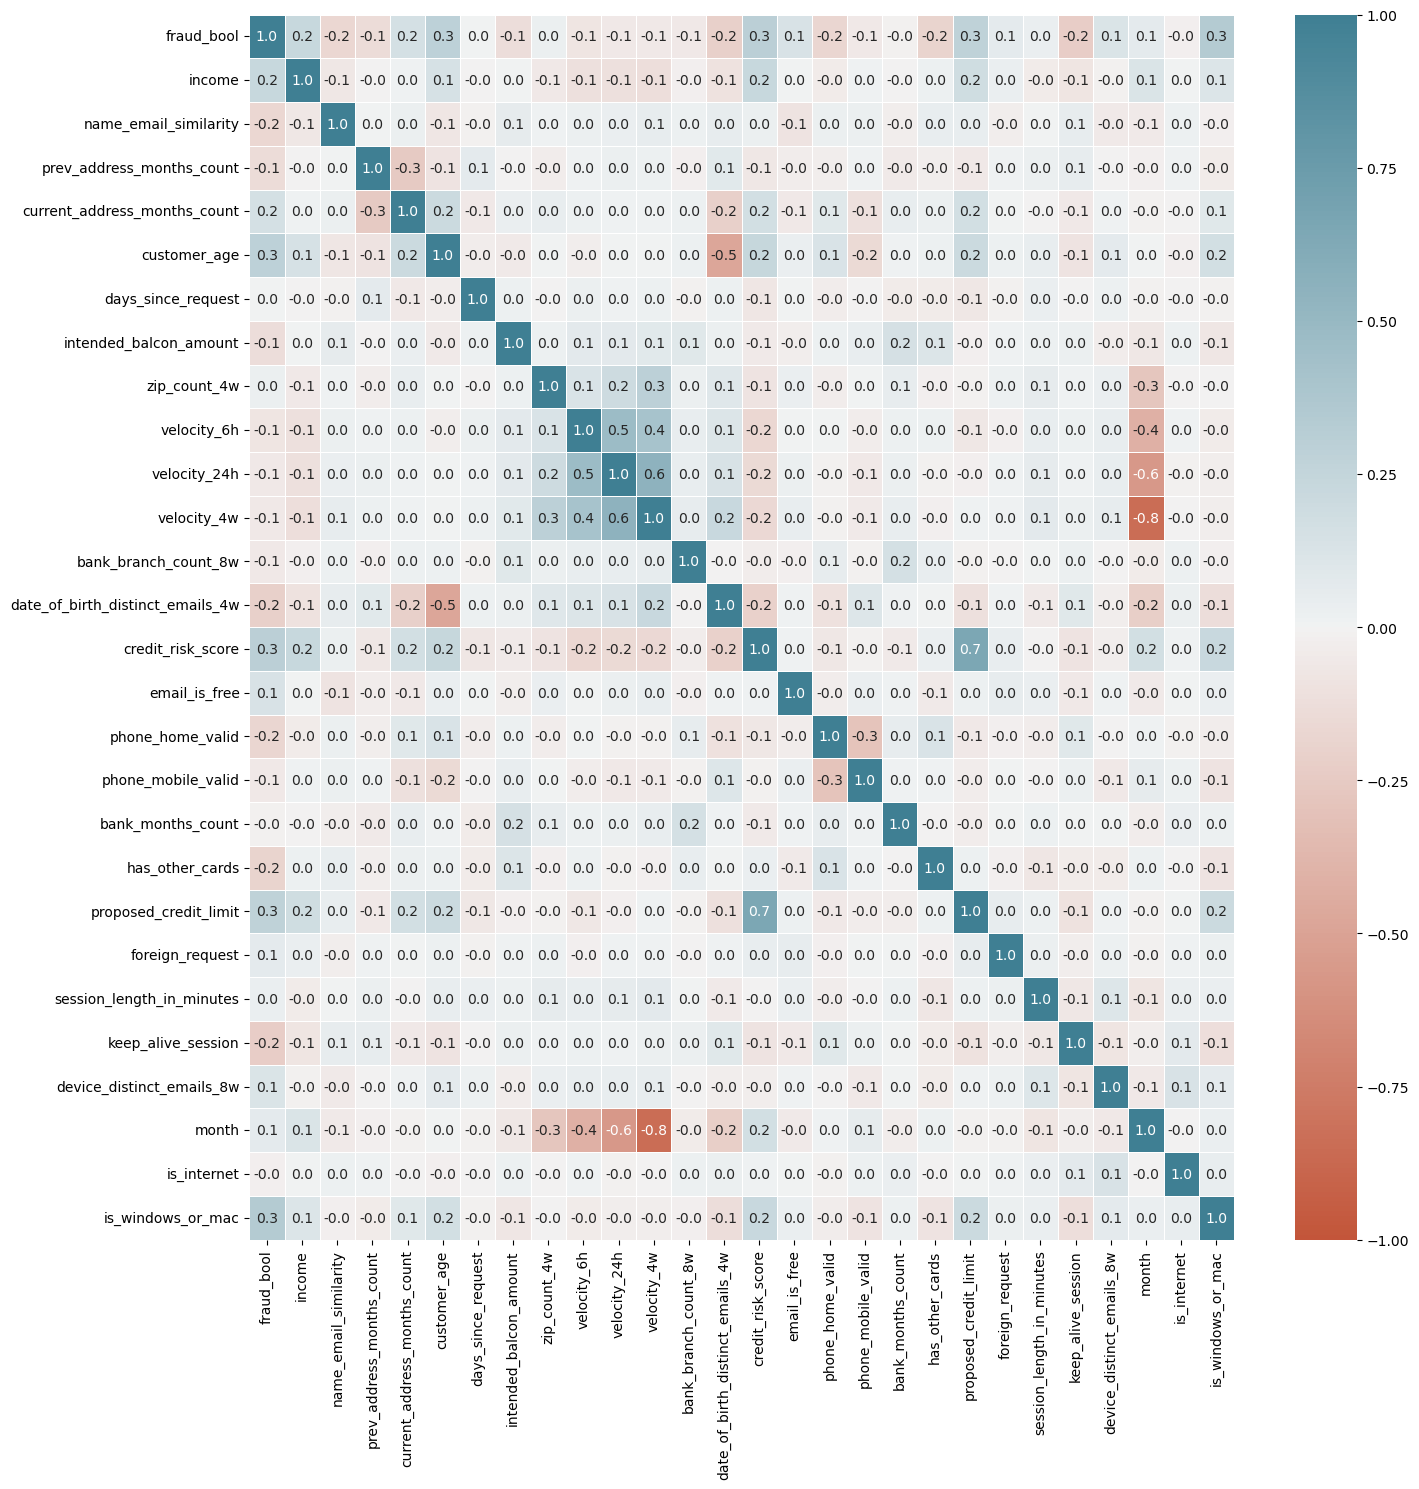

In [4]:
# Defining function to plot correlation heatmap of one of the dataframes in the list
def plot_heatmap(dataframe, plot_name):
    f,ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(
        dataframe.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,
        cmap=sns.diverging_palette(20, 220, as_cmap=True),
        vmin=-1, vmax=1
    )
    #heatmap.set_title('Correlation heatmap', fontdict={'fontsize':20}, pad=16)
    plt.tight_layout()
    plt.savefig('./img/' + plot_name + '.png')
    plt.show()
    plt.close()

# Plot heatmap
plot_heatmap(list_std[1], 'fig1_corr_ALL')


In [5]:
# Identifying pairs with high correlation

def get_highcorr(dataframe_number):
    corr = list_std[dataframe_number].corr().abs()
    tab = corr.unstack()
    print(tab[tab < 1].sort_values(ascending = False).head(10))

get_highcorr(2)

velocity_4w                       month                               0.845436
month                             velocity_4w                         0.845436
credit_risk_score                 proposed_credit_limit               0.655138
proposed_credit_limit             credit_risk_score                   0.655138
velocity_24h                      month                               0.549763
month                             velocity_24h                        0.549763
velocity_4w                       velocity_24h                        0.538999
velocity_24h                      velocity_4w                         0.538999
date_of_birth_distinct_emails_4w  customer_age                        0.483018
customer_age                      date_of_birth_distinct_emails_4w    0.483018
dtype: float64


# 4) Logistic regression with backward elimination

In [6]:
# Creating function specifying the model
def backward_elimination(X, y, sig_lvl=0.05):
    num_vars = len(X.columns)
    for i in range(0, num_vars):
        regressor_Logit = sm.Logit(y.astype(float), X.astype(float)).fit()
        max_var = max(regressor_Logit.pvalues)
        if max_var > sig_lvl:
            for j in range(0, num_vars - i):
                if (regressor_Logit.pvalues[j].astype(float) == max_var):
                    X = X.drop(X.columns[j], axis=1)
    return(regressor_Logit, X, y)

# Creating function to run the model using a given dataframe
def run_model(dataframe):
    # Separate features (X) and target variable (Y)
    X = dataframe.drop('fraud_bool', axis=1)
    y = dataframe['fraud_bool']

    # Add constant column to X for intercept
    X = sm.add_constant(X)

    # Perform backward elimination
    return(backward_elimination(X, y))

In [7]:
# Running the model through the list of dataframes
list_models = [run_model(df) for df in list_std]

Optimization terminated successfully.
         Current function value: 0.478449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478542
  

Optimization terminated successfully.
         Current function value: 0.474329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480448
  

In [8]:
# Printing regression results
[print(model.summary().tables[0]) for model, X, y in list_models]

                           Logit Regression Results                           
Dep. Variable:             fraud_bool   No. Observations:                22058
Model:                          Logit   Df Residuals:                    22036
Method:                           MLE   Df Model:                           21
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.3096
Time:                        23:24:02   Log-Likelihood:                -10556.
converged:                       True   LL-Null:                       -15289.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           Logit Regression Results                           
Dep. Variable:             fraud_bool   No. Observations:                22058
Model:                          Logit   Df Residuals:                    22035
Method:                           MLE   Df Model:                           22
Date:                Tue, 02 Apr 2024   Pseudo R-squ

[None, None, None, None, None]

In [9]:
# Printing features' coefficients
[print(model.summary().tables[1]) for model, X, y in list_models]

                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
income                               0.3391      0.018     19.139      0.000       0.304       0.374
name_email_similarity               -0.3489      0.017    -19.950      0.000      -0.383      -0.315
prev_address_months_count           -0.2741      0.020    -13.638      0.000      -0.313      -0.235
current_address_months_count         0.2127      0.019     11.387      0.000       0.176       0.249
customer_age                         0.3906      0.021     18.829      0.000       0.350       0.431
days_since_request                   0.0632      0.017      3.745      0.000       0.030       0.096
intended_balcon_amount              -0.1886      0.017    -10.800      0.000      -0.223      -0.154
zip_count_4w                         0.1195      0.018      6.696      0.000       0.085   

[None, None, None, None, None]

In [10]:
accuracies = []
cross_tabs = []
for i, model_tuple in enumerate(list_models):
    logit_model = model_tuple[0]
    X = model_tuple[1]
    y = model_tuple[2]
    df = list_std[0]

    df.loc[:, 'probability'] = logit_model.predict(X)
    df.loc[:, 'yhat'] = (df.probability > 0.5) * 1
    ct = pd.crosstab(df.fraud_bool, df.yhat)
    cross_tabs.append(ct)
    print(ct)

    # Find accuracy of the model using formula ACC=(TP+TN)/N
    acc = (ct.iloc[0][0] + ct.iloc[1][1]) / df.shape[0]
    accuracies.append(acc)
    print('Accuracy of the model is', acc, '\n')


yhat           0     1
fraud_bool            
0           8582  2447
1           2580  8449
Accuracy of the model is 0.7721008250974704 

yhat           0     1
fraud_bool            
0           8613  2416
1           2551  8478
Accuracy of the model is 0.7748209266479282 

yhat           0     1
fraud_bool            
0           8615  2414
1           2564  8465
Accuracy of the model is 0.7743222413636776 

yhat           0     1
fraud_bool            
0           8567  2462
1           2576  8453
Accuracy of the model is 0.7716021398132197 

yhat           0     1
fraud_bool            
0           8628  2401
1           2569  8460
Accuracy of the model is 0.7746849215704052 



In [11]:
print(f"Average accuracy for Fraud is {sum([ct.iloc[0][0] for ct in cross_tabs])/sum([ct.iloc[0][0]+ct.iloc[0][1] for ct in cross_tabs])}")
print(f"Average accuracy for non-Fraud is {sum([ct.iloc[1][1] for ct in cross_tabs])/sum([ct.iloc[1][0]+ct.iloc[1][1] for ct in cross_tabs])}")
print(f"Average accuracy is {sum(accuracies)/len(accuracies)}")

Average accuracy for Fraud is 0.7798531145162753
Average accuracy for non-Fraud is 0.7671593072808052
Average accuracy is 0.7735062108985403


# 5) Correlation analysis after BE

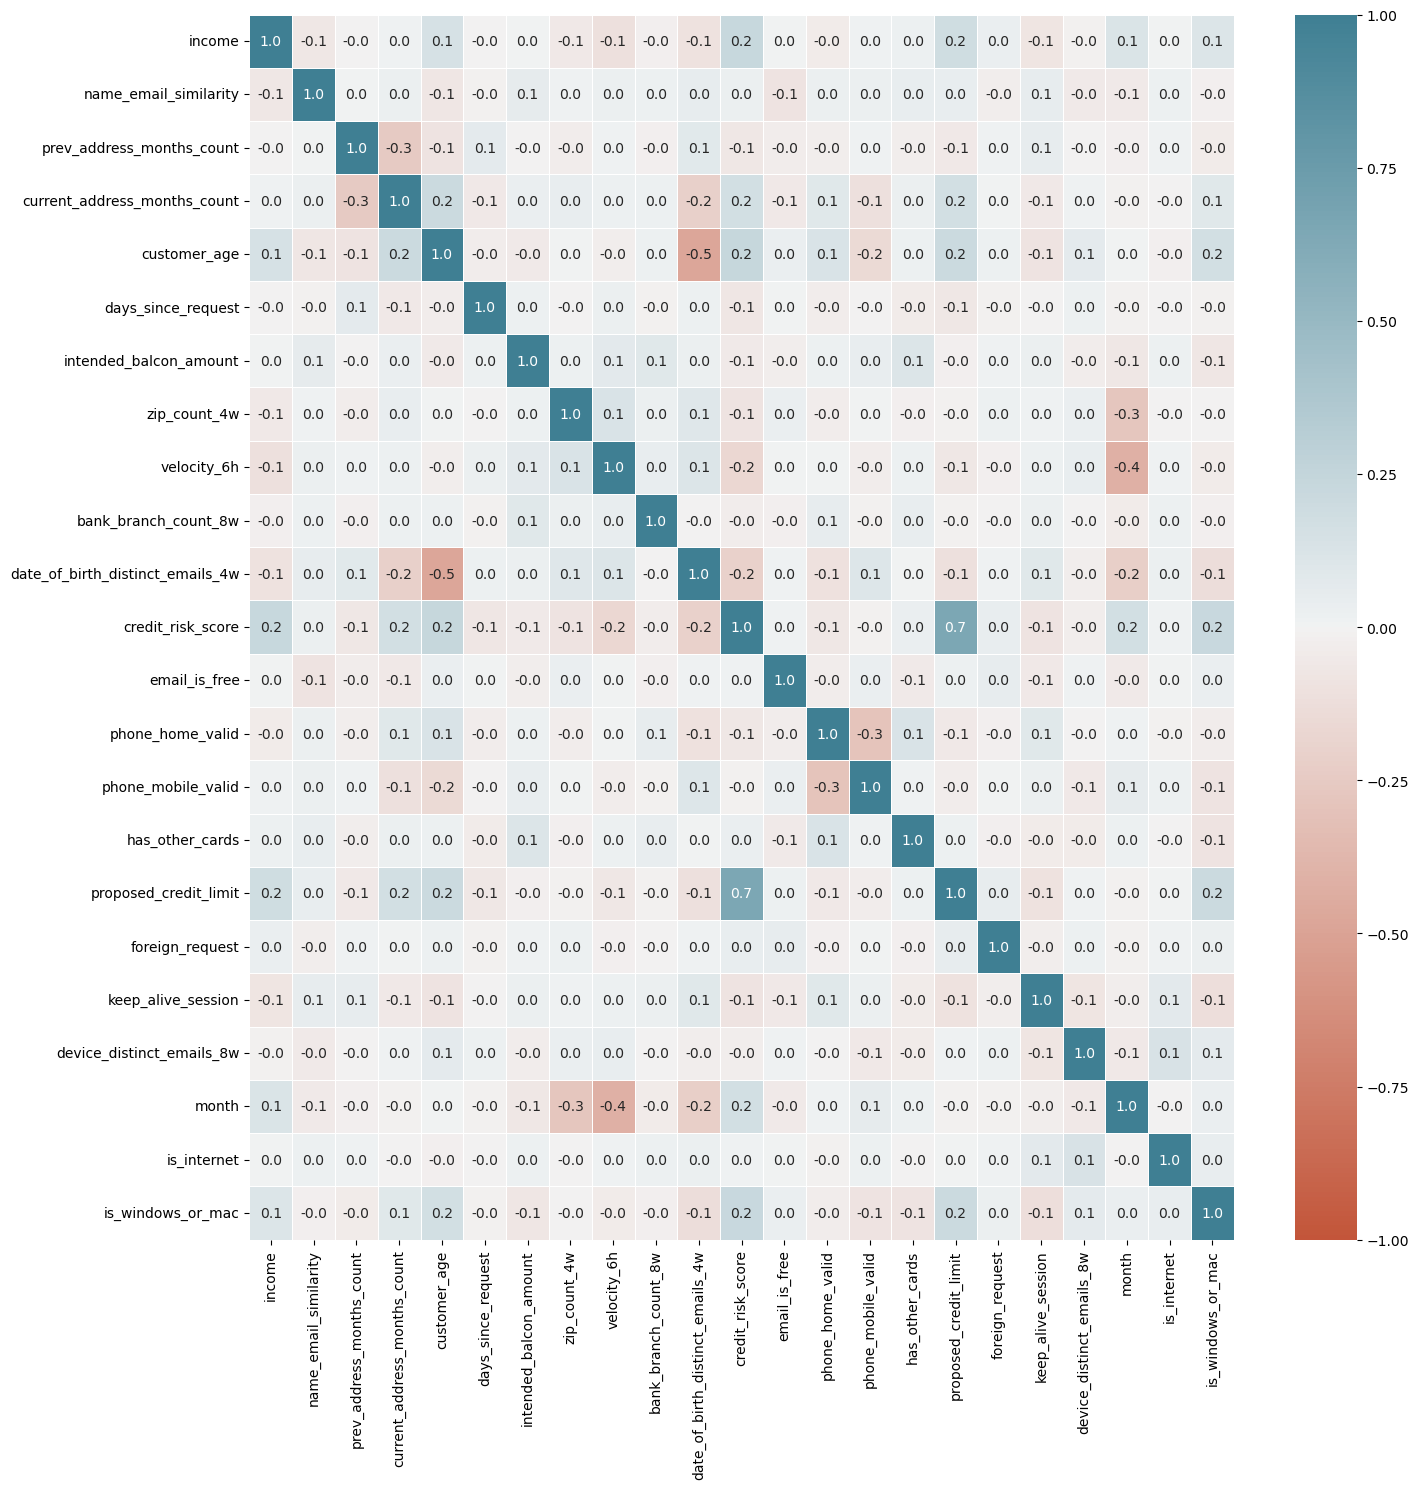

In [12]:
plot_heatmap(list_models[1][1], 'fig2_corr_BE')


# 6) Most Influential Coefficients

In [30]:
from collections import defaultdict
total_coefficient = defaultdict(int)
occurrence = defaultdict(int)

for model, _, _ in list_models:
    coefficients = model.params
    
    for i, column_name in enumerate(model.params.index):
        total_coefficient[column_name] += coefficients.values[i]
        occurrence[column_name] += 1

average = defaultdict(int)

for key, value in total_coefficient.items():
    average[key] = value / occurrence[key]
    
# Sort the dictionary by absolute values in descending order
sorted_items = sorted(average.items(), key=lambda x: abs(x[1]), reverse=True)

# Extract keys of the top 3 values
top_3_keys = [item[0] for item in sorted_items[:3]]

print("Coefficient of the top 3 values:")
for key in top_3_keys:
    print(key, ": ", average[key])

Keys of the top 3 values:
is_windows_or_mac :  0.5412005202560437
phone_home_valid :  -0.4923869732466528
has_other_cards :  -0.47991058890946015
